In [319]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import random_split, DataLoader

In [320]:
data_statistics = ((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
train_transforms_cifar = transforms.Compose([
    transforms.RandomCrop(32, padding=4, padding_mode= 'reflect'), 
    transforms.RandomHorizontalFlip(), 
    transforms.ToTensor(), # CxHxW
    transforms.Normalize(*data_statistics, inplace = True) # [-1, 1], data = (data - mean)/std_deviation
])

test_transforms_cifar = transforms.Compose([

    transforms.ToTensor(), # CxHxW
    transforms.Normalize(*data_statistics, inplace = True) # [-1, 1]
])
dataset = torchvision.datasets.CIFAR10(root="data/", download=True, transform=train_transforms_cifar)
test_dataset = torchvision.datasets.CIFAR10(root="data/", download=True, train=False, transform=test_transforms_cifar)

Files already downloaded and verified
Files already downloaded and verified


In [321]:
val_ratio = 0.2
train_size = int((1 - val_ratio) * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
batch_size = 64
train_dl = DataLoader(train_dataset, batch_size, shuffle=True, pin_memory=True)
val_dl = DataLoader(val_dataset, batch_size, shuffle=True, pin_memory=True)
test_dl = DataLoader(test_dataset, batch_size, pin_memory=True)

In [322]:
images, labels = next(iter(test_dl))
print(f"Images min: {images.min()}, max: {images.max()}")
print(f"Labels min: {labels.min()}, max: {labels.max()}")
for i in range(10):
    image, label = dataset[i]
    print(f"Image {i}: Label = {label}")

Images min: -1.0, max: 1.0
Labels min: 0, max: 9
Image 0: Label = 6
Image 1: Label = 9
Image 2: Label = 9
Image 3: Label = 4
Image 4: Label = 1
Image 5: Label = 1
Image 6: Label = 2
Image 7: Label = 7
Image 8: Label = 8
Image 9: Label = 3


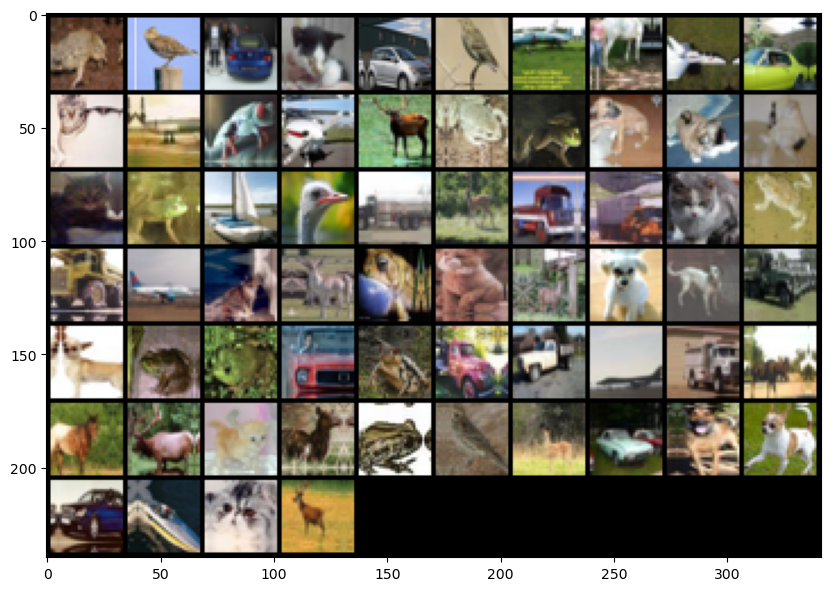

In [323]:
def denormalize(images, means, std_devs):
  # do reverse of normalization: image * sd_dev + mean
  means = torch.tensor(means).reshape(1, 3, 1, 1)
  std_devs = torch.tensor(std_devs).reshape(1, 3, 1, 1)
  return images * std_devs + means


def show_batch(dl):
  import matplotlib.pyplot as plt
  from torchvision.utils import make_grid
  for images, labels in dl:
    fig, ax = plt.subplots(figsize=(10,10))  
    images = denormalize(images, *data_statistics)
    ax.imshow(make_grid(images, 10).permute(1, 2, 0)) #HxWxC
    break

show_batch(train_dl)

In [324]:
def get_default_device():
  if torch.backends.mps.is_available():
    return torch.device("mps")  # Metal Performance Shaders
  elif torch.cuda.is_available():
    return torch.device("cuda")  # NVIDIA CUDA
  else:
    return torch.device("cpu")  # Fallback to CPU

def to_device(entity, device):
  if isinstance(entity, (list, tuple)):
    return [to_device(elem, device) for elem in entity]
  return entity.to(device, non_blocking=True) 

class DeviceDataLoader():
  '''
  wrapper around dataloaders to transfer batches to specified devices
  '''
  def __init__(self, dataloader, device):
    self.dl = dataloader
    self.device = device

  def __iter__(self):
    for b in self.dl:
      yield to_device(b, self.device)

  def __len__(self):
    return len(self.dl)

device = get_default_device() 
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
test_dl = DeviceDataLoader(test_dl, device)

In [325]:
###### Netork Architecture ######
'''
resnets: reidual block
inception
mobilenet 
'''
# model = ResnetX(in_channels, num_classes)
# logits = mode(images)
import torch.nn as nn
from collections import OrderedDict
def conv_block(in_channels, out_channels, pool = False):
  layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
            nn.BatchNorm2d(out_channels), 
            nn.ReLU(inplace=True)]
  if pool:
    layers.append(nn.MaxPool2d(2))
  return nn.Sequential(*layers)

class ResnetX(torch.nn.Module):
  def __init__(self, in_channels, num_classes):
    super().__init__()

    self.conv1 = conv_block(in_channels, 64)
    self.conv2 = conv_block(64, 128, pool=True)
    self.res1 = nn.Sequential(OrderedDict([("conv1res1", conv_block(128, 128)), ("conv2res1",conv_block(128, 128))])) 

    self.conv3 = conv_block(128, 256, pool=True)
    self.conv4 = conv_block(256, 512, pool=True)
    self.res2 = nn.Sequential(conv_block(512, 512), conv_block(512, 512))

    self.classifier = nn.Sequential(nn.MaxPool2d(4), 
                                    nn.Flatten(), 
                                    nn.Dropout(0.2),
                                    nn.Linear(512, num_classes))
  def forward(self, x):
    out = self.conv1(x)
    if torch.any(torch.isnan(out)):
      print("NaN found after conv1")
    out = self.conv2(out)
    if torch.any(torch.isnan(out)):
      print("NaN found after conv2")
    out = self.res1(out) + out
    if torch.any(torch.isnan(out)):
      print("NaN found after res1")
    out = self.conv3(out)
    if torch.any(torch.isnan(out)):
      print("NaN found after conv3")
    out = self.conv4(out)
    if torch.any(torch.isnan(out)):
      print("NaN found after conv4")
    out = self.res2(out) + out
    if torch.any(torch.isnan(out)):
      print("NaN found after res2")
    return self.classifier(out)





In [326]:
for images, labels in train_dl:
  if torch.any(torch.isnan(images)) or torch.any(torch.isinf(images)):
    print("NaN or Inf found in input images")

In [333]:
model = ResnetX(3, 10)

In [339]:
###### Network Training ######
def accuracy(logits, labels):
  pred, predClassId = torch.max(logits, dim=1) # BxN
  return torch.tensor(torch.sum(predClassId == labels).item() / len(logits))

def evaluate(model, dl, loss_func):
  model.eval()
  batch_losses, batch_accs = [], []
  for images, labels in dl:
        with torch.no_grad():
          logits = model(images)
        batch_losses.append(loss_func(logits, labels).item())
        batch_accs.append(accuracy(logits, labels))

  epoch_avg_loss = sum(batch_losses) / len(batch_losses)
  epoch_avg_acc = sum(batch_accs) / len(batch_accs)

  return epoch_avg_loss, epoch_avg_acc

def train(model, train_dl, val_dl, epochs, max_lr, loss_func, optim):
  #initialize optimizer 
  optimizer = optim(model.parameters(), max_lr)
  scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs * len(train_dl))

  results = []
  for epoch in range(epochs):
    model.train()
    train_losses = []
    lrs = []
    for images, labels in train_dl:
      #logits = model(images)
      logits = torch.clamp(model(images), min=-1e10, max=1e10)  # Clamp logits within a safe range
      loss = loss_func(logits, labels) # logits and labels are not one hot encoded
      train_losses.append(loss.item()) # Store scalar loss value
      loss.backward() # delta_loss / delta_model_parameters
      # Apply gradient clipping 
      torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
      optimizer.step()
      optimizer.zero_grad()
      scheduler.step()
      lrs.append(optimizer.param_groups[0]["lr"])
    epoch_train_loss = sum(train_losses) / len(train_losses)
    # NaN print(sum(train_losses))
    epoch_avg_loss, epoch_avg_acc = evaluate(model, val_dl, loss_func)

    # Store results
    results.append({
      'train_loss': epoch_train_loss,
      'val_loss': epoch_avg_loss,
      'val_acc': epoch_avg_acc,
      'lr': lrs[-1]
    })

    # Print training status
    print(f"Epoch {epoch + 1}/{epochs}: "
          f"Train Loss = {epoch_train_loss:.4f}, "
          f"Val Loss = {epoch_avg_loss:.4f}, "
          f"Val Acc = {epoch_avg_acc:.4f}, "
          f"Learning Rate = {lrs[-1]:.6f}")
          
    # Free up memory
    torch.mps.empty_cache()

  return results

In [340]:
#model = to_device(model, device)
epochs = 2
max_lr = 1e-2
loss_func = nn.CrossEntropyLoss() # cross entropy loss function allows for non one hot encoded vectors 
optim = torch.optim.Adam

In [341]:
%%time
model = to_device(model, device)
results = train(model, train_dl, val_dl, epochs, max_lr, loss_func, optim)
for result in results:
  print(result['val_acc'])

Epoch 1/2: Train Loss = nan, Val Loss = nan, Val Acc = 0.0000, Learning Rate = 0.008103


KeyboardInterrupt: 

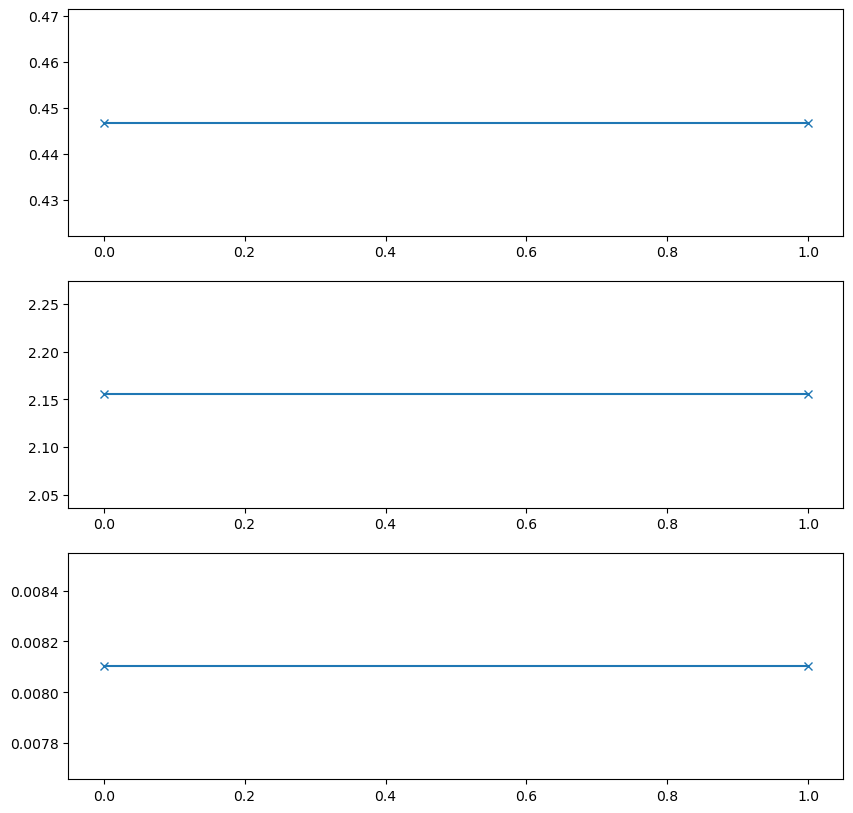

In [ ]:
def plot(results, pairs):
  import matplotlib.pyplot as plt
  fig, axes = plt.subplots(len(pairs), figsize=(10, 10))
  for i, pair in enumerate(pairs):
    for title, graphs in pair.items():
      axes[i].set_title = title
      axes[i].legen = graphs
      for graph in graphs:
        axes[i].plot([result[graph] for results in results], '-x')
plot(results, [{"Accuracies vs epochs": ['val_acc']}, {"Losses vs epochs": ['val_loss']}, {"Learning rates vs batches": ['lr']}])


In [338]:
test_acc = evaluate(model, test_dl, loss_func)
print(test_acc)

torch.save(model.state_dict(), "cifar10-ResNetX.pth")
model2 = ResnetX(3, 10)
test_acc = evaluate(model, test_dl, loss_func)
print(test_acc)

model2.load_state_dict(torch.load("cifar10-ResNetX.pth"))
test_acc = evaluate(model, test_dl, loss_func)
print(test_acc)

(nan, tensor(0.))
(nan, tensor(0.))


/var/folders/j3/r2b092mn3ml34bmrp580y3jw0000gn/T/ipykernel_27602/793960435.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model2.load_state_dict(torch.load("cifar10-Res

(nan, tensor(0.))
